In [2]:
from torchvision import transforms
from PIL import Image, ImageOps
import torch
import numpy as np
from modelscope import AutoImageProcessor

TARGET_HEIGHT = 416
TARGET_WIDTH = 512

class MixTexImageProcessor:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        self.to_tensor = transforms.ToTensor()

    def __call__(self, image: Image.Image):
        # 1. 转换 RGB
        image = image.convert("RGB")
        
        # 2. 计算保持比例的缩放尺寸
        iw, ih = image.size  # Input Width, Input Height
        w, h = TARGET_WIDTH, TARGET_HEIGHT
        
        scale = min(w / iw, h / ih)
        nw = int(iw * scale)
        nh = int(ih * scale)

        # 3. 缩放图片
        image = image.resize((nw, nh), Image.BICUBIC)

        # 4. 创建背景并填充 (Padding)
        # 255 表示白色背景，对于 OCR 很重要
        new_image = Image.new('RGB', (w, h), (255, 255, 255)) 
        
        # 5. 粘贴图片 (居中粘贴)
        paste_x = (w - nw) // 2
        paste_y = (h - nh) // 2
        new_image.paste(image, (paste_x, paste_y))

        # 6. 转 Tensor 并标准化 (Swin 需要 ImageNet 的 mean/std)
        # ToTensor 会把 [0, 255] 转为 [0.0, 1.0]
        tensor = self.to_tensor(new_image)
        
        # 手动标准化
        tensor = transforms.functional.normalize(
            tensor, mean=self.mean, std=self.std
        )
        
        return tensor

# 获取 Swin 的默认均值和方差
processor_cfg = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
custom_processor = MixTexImageProcessor(
    mean=processor_cfg.image_mean,
    std=processor_cfg.image_std
)

In [4]:
import torch
from modelscope import (
    SwinConfig, SwinModel, 
    RobertaConfig, RobertaForCausalLM, # 改用 RoBERTa
    VisionEncoderDecoderModel,
    AutoTokenizer, AutoImageProcessor
)

TARGET_HEIGHT = 416
TARGET_WIDTH = 512

# ============================
# Encoder: Swin Transformer
# ============================
encoder_config = SwinConfig.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
# 强制修改尺寸
encoder_config.image_size = (TARGET_HEIGHT, TARGET_WIDTH)

encoder = SwinModel.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    config=encoder_config,
    ignore_mismatched_sizes=True # 允许尺寸变化导致的权重插值
)

# ============================
# Tokenizer & Decoder: RoBERTa
# ============================
tokenizer = AutoTokenizer.from_pretrained("MixTeX/MixTex-ZhEn-Latex-OCR", use_fast=True)

# 使用 RoBERTa 配置 (对应论文参数)
decoder_config = RobertaConfig(
    vocab_size=len(tokenizer),
    hidden_size=768,
    num_hidden_layers=4,
    num_attention_heads=12,
    intermediate_size=3072,
    # 关键配置
    is_decoder=True,
    add_cross_attention=True,
    bos_token_id=tokenizer.cls_token_id, # RoBERTa 的开始符通常是 <s> (id 0)
    eos_token_id=tokenizer.sep_token_id,
    pad_token_id=tokenizer.pad_token_id,
    max_position_embeddings=512,
    type_vocab_size=1, # RoBERTa 不需要 token_type_ids
)

# 使用 CausalLM 头部，这样才有 lm_head 输出 logits
decoder = RobertaForCausalLM(decoder_config)

# ============================
# 拼装 VisionEncoderDecoder
# ============================
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

# 确保特殊 Token 对齐
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.vocab_size = len(tokenizer)

# 生成配置
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id
model.generation_config.pad_token_id = tokenizer.pad_token_id
model.generation_config.eos_token_id = tokenizer.sep_token_id
model.generation_config.max_length = 296

# ============================
# 再次检查数据类型 (常见坑)
# ============================
# 确保你的 mixtex dataset 返回的 pixel_values 是 Float32
# 有些 image processor 会返回 float64，导致训练极慢或出错
print("Model initialized correctly with pure Transformers lib.")

Model initialized correctly with pure Transformers lib.


In [5]:
from datasets import load_dataset
from PIL import Image
import torch
from torch.utils.data import Dataset

# raw_dataset = load_dataset("MixTex/Pseudo-Latex-ZhEn-1")

raw_dataset = load_dataset(
    "parquet",
    data_files="pseudo_latex_train.parquet",
    # split="train",
)

class MixTexDataset(Dataset):
    def __init__(
        self,
        hf_dataset_split,
        tokenizer,
        image_processor, # 传入上面定义的 custom_processor
        max_length=296,
    ):
        self.data = hf_dataset_split
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # 处理图片
        image = sample["image"]
        # 直接得到 tensor: [3, 400, 500]
        pixel_values = self.image_processor(image)

        # 处理文本
        text = sample["text"]
        labels = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt",
        ).input_ids.squeeze(0)

        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": pixel_values,
            "labels": labels,
        }

# 实例化 Dataset
split = raw_dataset["train"].train_test_split(test_size=0.01, seed=42)
train_dataset = MixTexDataset(split["train"], tokenizer, custom_processor)
val_dataset = MixTexDataset(split["test"], tokenizer, custom_processor)

In [11]:
import numpy as np
# 定义工具函数
def normalize(s: str) -> str:
    # 与论文一致：仅去除空白，不做结构等价
    return s.replace(" ", "").replace("\n", "")


def compute_metrics(eval_preds):
    pred_ids, label_ids = eval_preds

    # Token Accuracy
    correct = 0
    total = 0
    for p, l in zip(pred_ids, label_ids):
        for pi, li in zip(p, l):
            if li == -100:
                continue
            total += 1
            if pi == li:
                correct += 1
    token_acc = correct / max(total, 1)

    # Exact Match
    em_correct = 0
    for p, l in zip(pred_ids, label_ids):
        pred = tokenizer.decode(
            p,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )
        gt = tokenizer.decode(
            np.where(l != -100, l, tokenizer.pad_token_id),
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )
        if normalize(pred) == normalize(gt):
            em_correct += 1

    em = em_correct / len(pred_ids)

    return {
        "exact_match": em,
        "token_accuracy": token_acc,
    }

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator

data_collator = default_data_collator

# 使用 AdamW，但给 Encoder 和 Decoder 不同的学习率（这也是论文常见的做法）
# Encoder 已经是预训练的，LR 小一点；Decoder 是随机的，LR 大一点。
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 2e-5},  # Encoder 稍微解冻微调
    {'params': model.decoder.parameters(), 'lr': 1e-4}   # Decoder 随机初始化，需要大学习率
], weight_decay=0.01)

training_args = Seq2SeqTrainingArguments(
    output_dir="./mixtex_reproduce",
    per_device_train_batch_size=16, # 如果显存不够，减小这个，增大 gradient_accumulation_steps
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    fp16=True,
    
    # 论文说一共 5 个 epoch
    num_train_epochs=10, # 建议多设一点，观察收敛情况
    
    logging_steps=100,
    save_steps=1000,
    eval_steps=200,
    eval_strategy="steps",
    
    learning_rate=1e-4, # 这里会被 optimizer 覆盖，但在 scheduler 中会用到
    warmup_steps=1000,  # 稍微多一点 warmup 让 encoder 适应
    
    predict_with_generate=True,
    generation_max_length=296,
)

# 必须解冻 Encoder
for p in model.encoder.parameters():
    p.requires_grad = True

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None) # 传入自定义 optimizer，scheduler 默认为空会让 Trainer 自动创建
)

In [ ]:
trainer.train()

In [6]:
print(f"CLS: {tokenizer.cls_token_id}")
print(f"SEP: {tokenizer.sep_token_id}")
print(f"BOS: {tokenizer.bos_token_id}")
print(f"EOS: {tokenizer.eos_token_id}")
print(f"PAD: {tokenizer.pad_token_id}")
# 确保这三个完全对齐
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.generation_config.decoder_start_token_id = tokenizer.cls_token_id

# 很多 tokenizer 的 bos_token_id 是 None，这时候必须用 cls_token_id
if tokenizer.bos_token_id is not None:
    model.config.bos_token_id = tokenizer.bos_token_id
else:
    model.config.bos_token_id = tokenizer.cls_token_id

CLS: 0
SEP: 25678
BOS: 0
EOS: 25678
PAD: 1


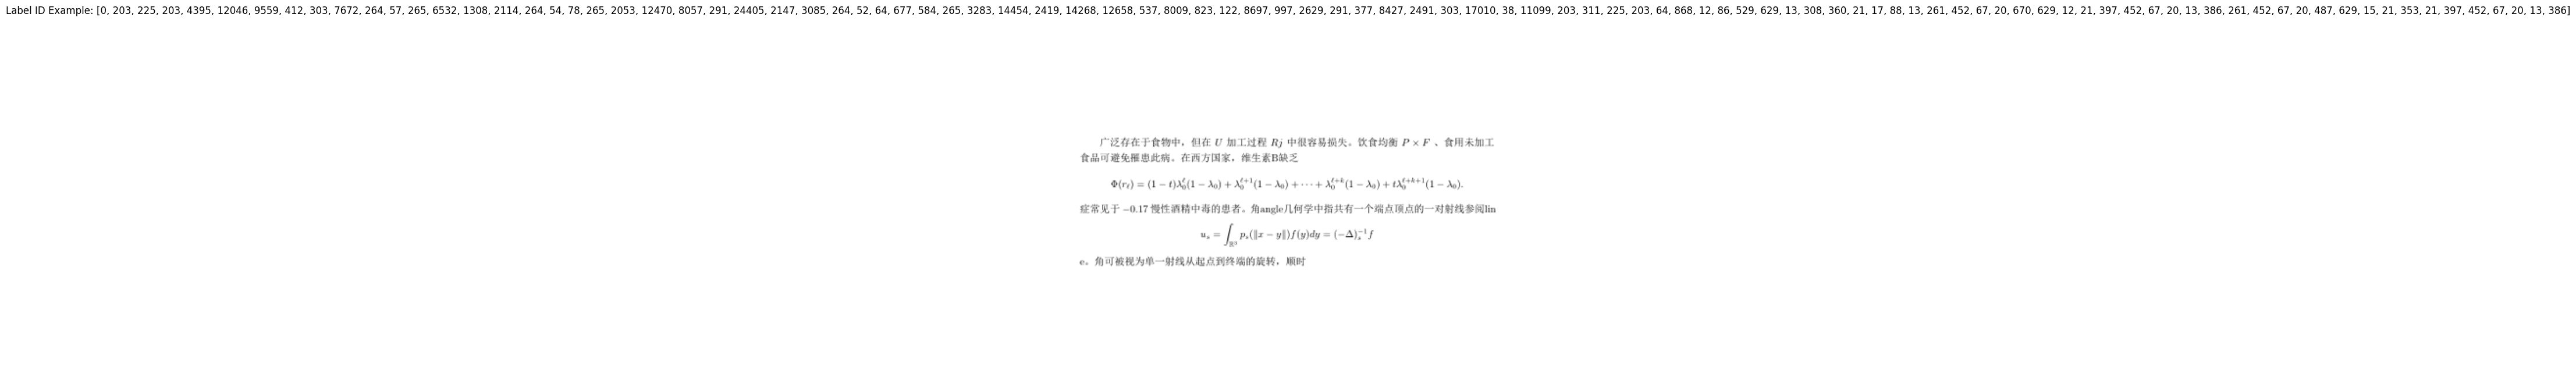

Image Shape: torch.Size([3, 416, 512])


In [19]:
import matplotlib.pyplot as plt
import torch

# 1. 取出一个 batch
batch = next(iter(trainer.get_train_dataloader()))

# 2. 获取图片 tensor 并立刻转到 CPU
# 关键修改：加上 .cpu()
img_tensor = batch["pixel_values"][0].cpu() 

# 3. 定义反归一化参数 (Swin 的默认 mean/std)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# 4. 反归一化
# 现在 img_tensor, mean, std 都在 CPU 上，不会报错了
img = img_tensor * std + mean

# 5. 限制范围并转为 numpy
img = img.clamp(0, 1)
img_np = img.permute(1, 2, 0).numpy()

# 6. 画图
plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.axis('off')
plt.title(f"Label ID Example: {batch['labels'][0][:100].tolist()}")
plt.show()

# 打印一下形状，确认是不是我们修改后的尺寸 (例如 3, 416, 512)
print(f"Image Shape: {img_tensor.shape}")